In [1]:
import sys
print sys.executable

paths = ['', '/Users/dyawitz/anaconda/bin', '/Users/dyawitz/anaconda/lib/python27.zip', '/Users/dyawitz/anaconda/lib/python2.7/plat-darwin', '/Users/dyawitz/anaconda/lib/python2.7/plat-mac', '/Users/dyawitz/anaconda/lib/python2.7/plat-mac/lib-scriptpackages', '/Users/dyawitz/anaconda/lib/python2.7/lib-tk', '/Users/dyawitz/anaconda/lib/python2.7/lib-old', '/Users/dyawitz/anaconda/lib/python2.7/lib-dynload', '/Users/dyawitz/anaconda/lib/python2.7/site-packages/Sphinx-1.3.1-py2.7.egg', '/Users/dyawitz/anaconda/lib/python2.7/site-packages/setuptools-18.5-py2.7.egg', '/Users/dyawitz/anaconda/lib/python2.7/site-packages', '/Users/dyawitz/anaconda/lib/python2.7/site-packages/aeosa', '/Users/dyawitz/anaconda/lib/python2.7/site-packages/IPython/extensions', '/Users/dyawitz/.ipython']

for i in paths:
   sys.path.append(i)

/Users/dyawitz/anaconda/envs/py27/bin/python


In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score
%matplotlib inline

In [3]:
full = pd.read_csv('capital2001.csv')
full['timestamp'] = full.timestamp.apply(lambda x: pd.to_datetime(x))

In [4]:
full.columns

Index([u'Unnamed: 0', u'timestamp', u'load', u'weathertime', u'temperaturef',
       u'dewpointf', u'humidity', u'sealevelpressurein', u'winddirection',
       u'windspeedmph', u'precipitationin', u'dow', u'doy', u'day', u'month',
       u'hour', u'minute', u'year', u't_m1', u't_m24', u't_m48', u'tdif',
       u'summer', u'discomfort_index', u'ind'],
      dtype='object')

In [251]:
with_forecast.columns

Index([u'timestamp', u'load', u'weathertime', u'temperaturef', u'dewpointf',
       u'humidity', u'sealevelpressurein', u'winddirection', u'windspeedmph',
       u'precipitationin', u'dow', u'doy', u'day', u'month', u'hour',
       u'minute', u'year', u't_m1', u't_m24', u't_m48', u'tdif', u'summer',
       u'discomfort_index', u'ind', u'zone', u'forecast', u'nyiso_mape'],
      dtype='object')

In [140]:
def deviance_plot(est, X_test, y_test, ax = None, label = '', train_color='#2c7bb6', test_color = '#d7191c', alpha= 1.0, ylim = (0,60000)):

    n_estimators = len(est.estimators_)
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
        test_dev[i] = est.loss_(y_test, pred)

    if ax is None:
        fig = plt.figure(figsize = (18,6))
        ax = plt.gca()

    ax.plot(np.arange(n_estimators) + 1, test_dev, color= test_color, label = 'Test %s' % label, linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color = train_color, label= 'Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim(ylim)
    ax.legend(loc='upper right')
    return test_dev, ax

def get_daily_values(X_test, y_test, gbr, full):
    p = X_test.copy()
    p['load'] = y_test
    p['times'] = full[full.timestamp >= pd.to_datetime('2014')]['timestamp']
    p['prediction'] = gbr.predict(X_test)
    p['error'] = np.abs(p['load'] - p['prediction'])
    p = p.set_index(p.times)
    daily_values = p.groupby(pd.TimeGrouper(freq='D')).aggregate(np.max)
    return daily_values

def plot_model_performance(X_test, y_test, gbr, full):
    daily_values = get_daily_values(X_test, y_test, gbr, full)
    times = daily_values.index
    fig, ax1 = plt.subplots(figsize=(18, 6),)
    ax1.plot(times, daily_values['load'], alpha=.5, color='blue', label='actual load' )
    ax1.plot(times, daily_values['prediction'], alpha=.5, color='red', label="Dan's predicted load, %.3f" %gbr.score(X_test, y_test))
    ax1.plot(times, daily_values['error'], alpha=.5, color = 'green', label='error')
    ax1.legend(loc='best')
    ax2 = ax1.twinx()
    ax2.plot(times, daily_values['temperaturef'], alpha = .5, color = 'orange', label='temperature')
#     ax2.plot(times, daily_values['discomfort_index'], alpha = .5, color = 'brown', label='discomfort_index')

#     ax2.plot(times, daily_values['dewpointf'], alpha = .5, color = 'yellow', label='dew point')
#     ax2.plot(times, daily_values['precipitationin'], alpha = .5, color = 'brown', label='precip')
    ax2.legend(loc='lower right')
    return ax1, ax2

def plot_days(gbr, full, day1='2016-02-29', day2='2016-03-02', weather=False):
    test_day = full[full.timestamp >= pd.to_datetime(day1)]
    test_day = test_day[test_day.timestamp < pd.to_datetime(day2)]
    predictions = gbr.predict(test_day[features])
    score = gbr.score(test_day[features], test_day['load'])    
    
    fig, ax = plt.subplots(figsize=(18, 6),)
    ax.plot(test_day.timestamp.values, test_day.load.values, label = 'actual load', color = 'blue')
    ax.plot(test_day.timestamp.values, predictions, label = "Dan's predicted load. R^2 = %.2f"%score, color= 'red')
    if weather == True:
        ax2 = ax.twinx()
        ax2.plot(test_day.timestamp.values, test_day.temperaturef.values, label = 'temperature', color= 'orange')
    ax.legend(loc='best')
    ax.set_title(day1 + ' - '+ day2 + ' \n NYISO Capital Region ')
    ax.set_xlabel('time')
    ax.set_ylabel('load (megawatts)')
    return ax
    

In [334]:
features = [\
#           'dewpointf', \
#           'humidity', \
#           'sealevelpressurein', \
#          'windspeedmph', \
            'year',\
#           'precipitationin',\
          'doy',\
          'dow', \
#           'month',\
#           'hour',\
         'minute',\
#             'summer',\
#           't_m24', \
#           't_m48', \
#           't_m1',\
#             'tdif'
            'temperaturef',\
         ]

In [335]:
X_train = full[full.timestamp < pd.to_datetime('2014')][features]
X_test = full[full.timestamp >= pd.to_datetime('2014')][features]

y_train = full[full.timestamp < pd.to_datetime('2014')]['load']
y_test = full[full.timestamp >= pd.to_datetime('2014')]['load']

In [336]:
gbr = GradientBoostingRegressor(loss='ls', n_estimators=100, max_depth=4, verbose=1, warm_start=True)

In [337]:
gbr_fitted = gbr.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1       55349.2095            1.71m
         2       48298.4598            1.76m
         3       42467.5860            1.72m
         4       37558.1722            1.69m
         5       33448.5465            1.68m
         6       30000.0388            1.68m
         7       27198.0393            1.68m
         8       24693.1320            1.65m
         9       22674.2247            1.63m
        10       20968.5704            1.61m
        20       12386.0669            1.38m
        30        9193.9095            1.18m
        40        7786.2204           59.49s
        50        7051.2982           48.80s
        60        6540.1980           38.61s
        70        6164.8151           28.72s
        80        5940.8970           19.03s
        90        5759.8818            9.46s
       100        5615.4558            0.00s


In [338]:
gbr.score(X_test, y_test)

0.86259835868993384

In [339]:
zip(features, [float(i) for i in gbr.feature_importances_])

[('year', 0.11424954650926156),
 ('doy', 0.26627317165301123),
 ('dow', 0.07134777146326444),
 ('minute', 0.34803720424607687),
 ('temperaturef', 0.2000923061283858)]

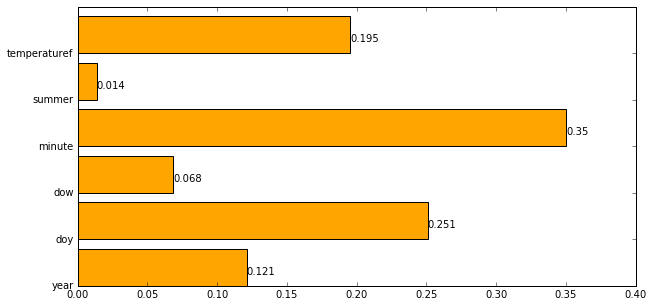

In [272]:
fi = list(gbr.feature_importances_)

fig, ax = plt.subplots(figsize=(10,5),)
ax.barh(np.arange(len(fi)), fi, color = 'orange')
for i, v in enumerate(fi):
    ax.text(v, i + .25, str(round(v, 3)))
ax.set_yticks(np.arange(len(fi)))
ax.set_yticklabels(features)

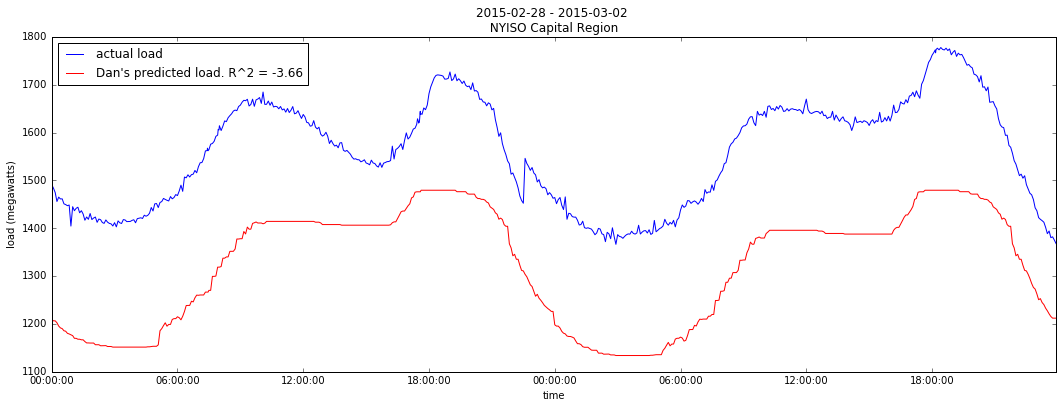

In [202]:
plot_days(gbr, full, '2015-02-28', '2015-03-02')

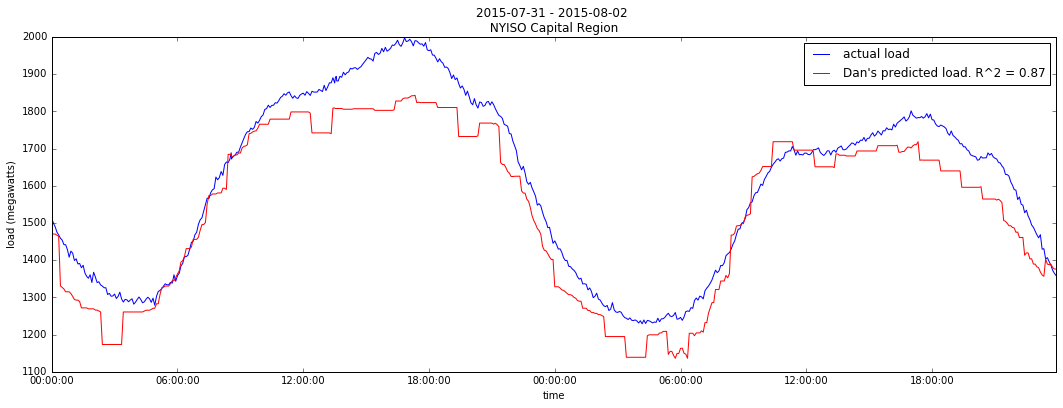

In [179]:
plot_days(gbr, full, '2015-07-31', '2015-08-02')

In [180]:
plot_days(gbr, full, '2015-10-30', '2015-11-03')

In [83]:
capital_forecast = pd.read_csv('../data/nyiso_dayahead_forecasts/capital_forecast.csv')
capital_forecast['timestamp'] = capital_forecast.timestamp.apply(lambda x: pd.to_datetime(x))

In [181]:
subset_2014_2016 = full[full.timestamp > pd.to_datetime('2014')]

In [182]:
subset_2014_2016 = subset_2014_2016[subset_2014_2016.minute % 60 == 0]

In [183]:
with_forecast = pd.merge(subset_2014_2016, capital_forecast, on='timestamp')

In [184]:
with_forecast.columns

Index([u'Unnamed: 0', u'timestamp', u'load', u'weathertime', u'temperaturef',
       u'dewpointf', u'humidity', u'sealevelpressurein', u'winddirection',
       u'windspeedmph', u'precipitationin', u'dow', u'doy', u'day', u'month',
       u'hour', u'minute', u'year', u't_m1', u't_m24', u't_m48', u'tdif',
       u'summer', u'discomfort_index', u'ind', u'zone', u'forecast'],
      dtype='object')

In [186]:
with_forecast.drop('Unnamed: 0', axis=1, inplace=True)

In [187]:
with_forecast['nyiso_mape'] = np.abs(with_forecast['load'] - with_forecast['forecast'])/with_forecast['load']

In [421]:
def compare_models(with_forecast, gbr, day1, day2, weather=False):
    test_day = with_forecast[with_forecast.timestamp >= pd.to_datetime(day1)]
    test_day = test_day[test_day.timestamp < pd.to_datetime(day2)]
    predictions = gbr.predict(test_day[features])
    
    end_day = (pd.to_datetime(day2) - pd.Timedelta('1 day')).strftime('%Y-%m-%d')
    
    mape = np.mean(np.abs(predictions - test_day['load'])/test_day['load'])
    score = gbr.score(test_day[features], test_day['load'])
    nyiso_mape = np.mean(test_day['nyiso_mape'])
    nyiso_score = gbr.score(test_day[features], test_day['forecast'])
    
    fig, ax = plt.subplots(figsize=(18, 8),)
    
    ax.plot(test_day.timestamp.values, test_day.load.values, label = 'actual load', color = 'blue', linewidth=3)
    
    ax.plot(test_day.timestamp.values, predictions, ls= 'dashed', lw=2,\
            label = "Dan's predicted load,R^2 = {0:.3f}, MAPE = {1:.3f}".format(score,mape), color= 'red')
    
    ax.plot(test_day.timestamp.values, test_day.forecast.values, ls='dashed', lw=2,\
            label = 'NYISO day ahead forecast,  R^2 = {0:.3f}, MAPE = {1:.3f}'.format(nyiso_score, nyiso_mape), color = 'green')
    
    if weather == True:
        ax2 = ax.twinx()
        ax2.plot(test_day.timestamp.values, test_day.temperaturef.values, label = 'temperature', color= 'orange')
#     ax.legend(loc='best')
#     ax.set_title(day1 + ' - '+ end_day + ' \n NYISO Capital Region ', fontsize=20)
    ax.set_xlabel('time', fontsize=16)
    ax.set_ylabel('load (megawatts)', fontsize=16)
    ax.set_ylim(1000,2200)
    return ax

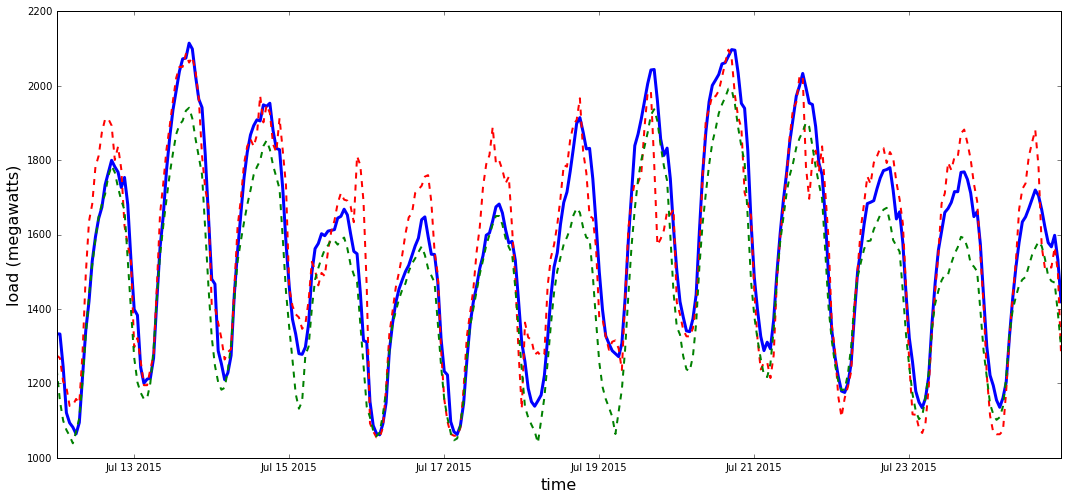

In [429]:
compare_models(with_forecast, gbr, '2015-07-12', '2015-07-25', weather=False)

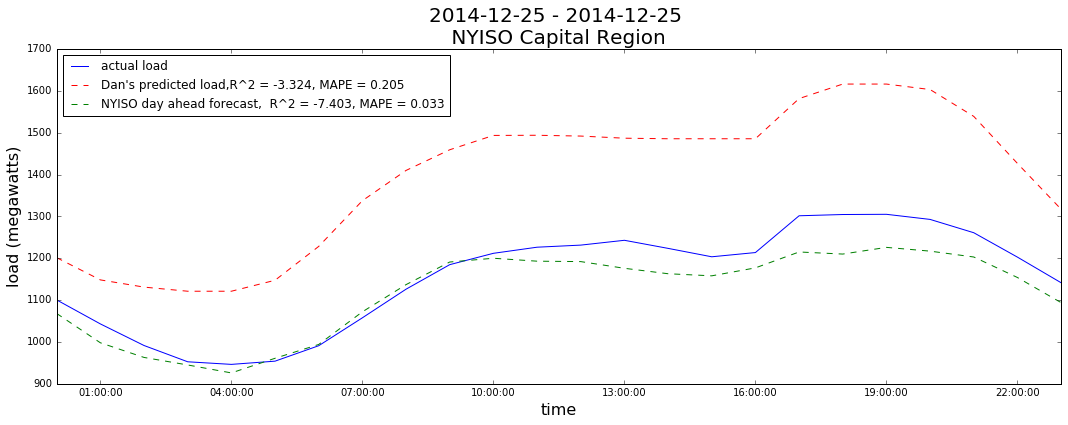

In [222]:
compare_models(with_forecast, gbr, '2014-12-25', '2014-12-26')

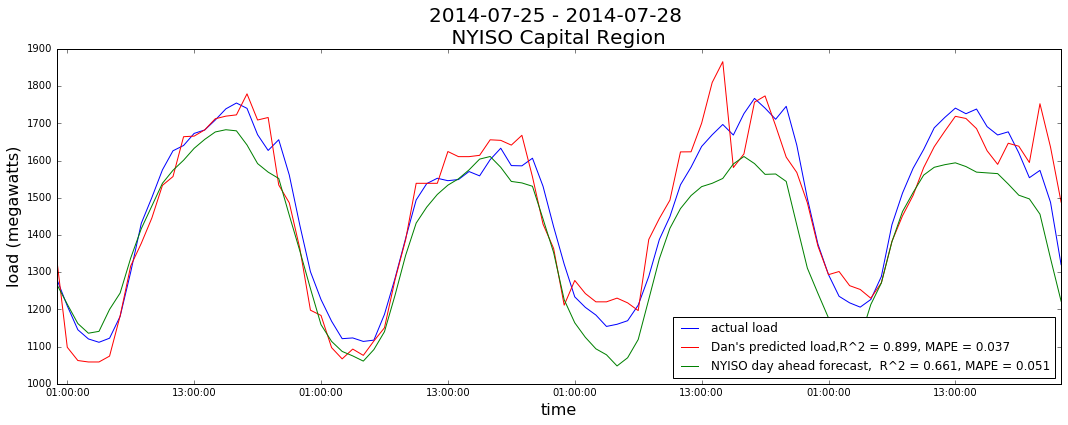

In [192]:
compare_models(with_forecast, gbr, '2014-07-25', '2014-07-29')

In [350]:
#48 hour temperature forecast for 3/29 - 3/30. Pulled 5pm, 3/28
forecast_48 = [46,47,47,46,45,43,42,41,41,40,39,38,37,36,36,37,38,40,41,43,44,44,45,45,45,43,41,38,36,34,32,31,30,28,27,26,26,25,25,28,34,39,43,47,51,54,55,56,56,52,49,47,46,45,45,44,42,41,40,39,39,39,39,42,46,50,54,57,60,62,63,64]

In [213]:
phour = pd.Timedelta('1 hour')
start_time = pd.to_datetime('2016-03-28, 17:00')

In [218]:
timestamp_48 = [(start_time + phour*i) for i in range(0,72)]

In [332]:
day_ahead = pd.DataFrame({'timestamp': timestamp_48, 'temperaturef':forecast_48})

In [ ]:
[('year', 0.11424954650926156),
 ('doy', 0.26627317165301123),
 ('dow', 0.07134777146326444),
 ('minute', 0.34803720424607687),
 ('temperaturef', 0.2000923061283858)]

In [349]:
day_ahead['year'] = day_ahead.timestamp.apply(lambda x: x.year)
day_ahead['doy'] = day_ahead.timestamp.apply(lambda x: x.dayofyear)
day_ahead['dow'] = day_ahead.timestamp.apply(lambda x: x.dayofweek)
day_ahead['minute'] = day_ahead.timestamp.apply(lambda x: x.hour* 60 + x.minute)
day_ahead['gbr_prediction'] = gbr.predict(day_ahead[features])

In [352]:
forecast_48 = pd.read_csv('../data/nyiso_dayahead_forecasts/forecast_20160328.csv')

In [354]:
day_ahead['nyiso_forecast'] = forecast_48.forecast

In [469]:
rt_load = pd.read_csv('../data/nyiso_dayahead_forecasts/20160328_realtime.csv')

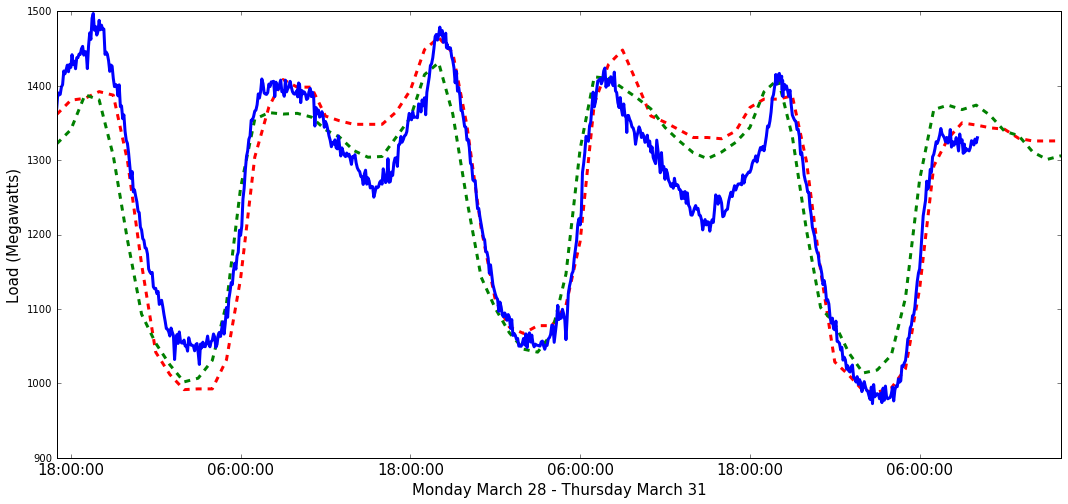

In [470]:
fig, ax1 = plt.subplots(figsize=(18, 8),)
# ax1.plot(times, daily_values['load'], alpha=.5, color='navy', label='actual load', lw=3)
ax1.plot(day_ahead.timestamp, day_ahead['gbr_prediction'], alpha=1, color='red', lw=3, ls='dashed')
ax1.plot(day_ahead.timestamp, day_ahead['nyiso_forecast'], alpha=1, color = 'green', lw=3, ls='dashed')
ax1.plot(rt_load.timestamp, rt_load.load, color = 'blue', lw=3)
# ax1.legend(loc='best')
ax1.set_xlabel('Monday March 28 - Thursday March 31', fontsize=15)
ax1.tick_params(axis='x', labelsize=15)
ax1.set_ylabel('Load (Megawatts)', fontsize=15)

In [449]:
rt_load['timestamp'] = rt_load.timestamp.apply(lambda x: pd.to_datetime(x))
rt_load['minute'] = rt_load.timestamp.apply(lambda x: x.minute)

In [450]:
scoring = rt_load[rt_load.minute % 60 ==0 ]

In [466]:
print "For March 28-31 2016, my model's R2 = ", r2_score(scoring.load, day_ahead['gbr_prediction'][:len(scoring)])
print "For March 28-31 2016, the NYISO R2 = ", r2_score(scoring.load, day_ahead['nyiso_forecast'][:len(scoring)])

For March 28-31 2016, my model's R2 =  0.690608092869
For March 28-31 2016, the NYISO R2 =  0.512725506452


In [467]:
from sklearn.metrics import mean_absolute_error

In [476]:
print "For March 28-31 2016, my model's MAE = ", mean_absolute_error(scoring.load, day_ahead['gbr_prediction'][:len(scoring)])
print "For March 28-31 2016, the NYISO MAE = ", mean_absolute_error(scoring.load, day_ahead['nyiso_forecast'][:len(scoring)])

For March 28-31 2016, my model's MAE =  60.1585035707
For March 28-31 2016, the NYISO MAE =  69.5581818182


In [495]:
def mean_absolute_percentage_error(y_true, y_pred):
    ape = np.abs(y_true  - y_pred)/y_true
#     for t, p in list(y_true.values), list(y_pred.values):
#         ape.append(np.abs(t - p)/ t )
#     y_true, y_pred = check_array(y_true, y_pred)
    
    return np.mean(ape)*100

In [497]:
print "For March 28-31 2016, my model's MAPE = ", mean_absolute_percentage_error(scoring.load, day_ahead['gbr_prediction'][:len(scoring)])
print "For March 28-31 2016, the NYISO MAPE = ", mean_absolute_percentage_error(scoring.load, day_ahead['nyiso_forecast'][:len(scoring)])

For March 28-31 2016, my model's MAPE =  12.9092072325
For March 28-31 2016, the NYISO MAPE =  12.5470372013


In [498]:
print "For 2014-2016, my model's MAPE = ", mean_absolute_percentage_error(with_forecast['load'], gbr.predict(with_forecast[features]))
print "For 2014-2016, the NYISO MAPE = ", mean_absolute_percentage_error(with_forecast['load'], with_forecast['forecast'])

For 2014-2016, my model's MAPE =  4.79558589766
For 2014-2016, the NYISO MAPE =  4.67055917116


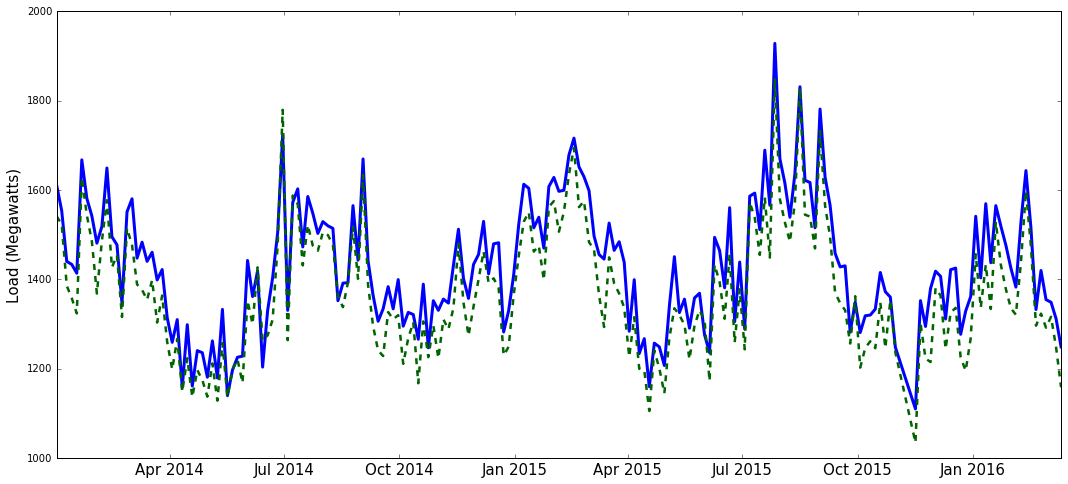

In [471]:
p = with_forecast.set_index(with_forecast.timestamp)

nyiso_score = r2_score(with_forecast['load'], with_forecast['forecast'])
model_score = r2_score(with_forecast['load'], gbr.predict(with_forecast[features]))

daily_values = p.groupby(pd.TimeGrouper(freq='4D')).aggregate(np.median)
daily_values.dropna(inplace=True)
twoyear_prediction = gbr.predict(daily_values[features])
times = daily_values.index


fig, ax1 = plt.subplots(figsize=(18, 8),)
ax1.plot(times, daily_values['load'], alpha=1, color='BLUE', label='actual load', lw=3)
# ax1.plot(times, twoyear_prediction, alpha=1, color='red', label="GBR predicted load, 0.884" %model_score, lw=2.5, ls='dashed')
ax1.plot(times, daily_values['forecast'], alpha=1, color = 'darkgreen', label='NYISO forecast, %.3f' %nyiso_score, lw=2.5, ls='dashed')
# ax1.legend(loc='best')
# ax1.set_xlabel('Date', fontsize=14)
ax1.tick_params(axis='x', labelsize=15)
ax1.set_ylabel('Load (Megawatts)', fontsize=15)
# ax2 = ax1.twinx()
#     ax2.plot(times, daily_values['temperaturef'], alpha = .5, color = 'orange', label='temperature')
#     ax2.plot(times, daily_values['discomfort_index'], alpha = .5, color = 'brown', label='discomfort_index')

#     ax2.plot(times, daily_values['dewpointf'], alpha = .5, color = 'yellow', label='dew point')
#     ax2.plot(times, daily_values['precipitationin'], alpha = .5, color = 'brown', label='precip')
# ax2.legend(loc='lower right')


In [473]:
print nyiso_score
print model_score

0.882233047224
0.862490890278
